In [20]:
from torch_geometric.data import HeteroData, DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv , GCNConv , SAGEConv , GATConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

import torch
from torch import nn 
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder , label_binarize , OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore") 


In [2]:
path_work = "/media/concha-eloko/Linux/PPT_clean"
graph_data = torch.load(f'{path_work}/graph_file.1107.pt')

graph_data

HeteroData(
  A={ x=[4530, 127] },
  B1={ x=[11339, 0] },
  B2={ x=[3608, 1280] },
  (B1, infects, A)={
    edge_index=[2, 9677],
    y=[9677]
  },
  (B2, expressed, B1)={
    edge_index=[2, 13285],
    y=[13285]
  },
  (A, harbors, B1)={
    edge_index=[2, 9677],
    y=[9677]
  }
)

In [4]:
# *****************************************************************************
# Pre-process data :
transform = T.RandomLinkSplit(
    num_val=0.1, 
    num_test=0.2, 
    #disjoint_train_ratio=...,  
    neg_sampling_ratio=1.0,  
    add_negative_train_samples=True, 
    edge_types=("B1", "infects", "A"),
    rev_edge_types=("A", "harbors", "B1"), 
)

train_data, val_data, test_data = transform(graph_data)

train_loader = LinkNeighborLoader(
    data=train_data,  
    num_neighbors= [-1],  
    edge_label_index=(("B1", "infects", "A"), train_data["B1", "infects", "A"].edge_label_index),
    edge_label=train_data["B1", "infects", "A"].edge_label,
    batch_size=128,
    shuffle=True,
)

val_loader = LinkNeighborLoader(
    data=val_data,  
    num_neighbors= [-1],  
    edge_label_index=(("B1", "infects", "A"), val_data["B1", "infects", "A"].edge_label_index),
    edge_label=val_data["B1", "infects", "A"].edge_label,
    batch_size=128,
    shuffle=True,
)

test_loader = LinkNeighborLoader(
    data=test_data,  
    num_neighbors= [-1],  
    edge_label_index=(("B1", "infects", "A"), test_data["B1", "infects", "A"].edge_label_index),
    edge_label=test_data["B1", "infects", "A"].edge_label,
    batch_size=128,
    shuffle=True,
)

In [131]:
train_data

HeteroData(
  A={ x=[4530, 127] },
  B1={ x=[11339, 0] },
  B2={ x=[3608, 1280] },
  (B1, infects, A)={
    edge_index=[2, 6775],
    y=[6775],
    edge_label=[13550],
    edge_label_index=[2, 13550]
  },
  (B2, expressed, B1)={
    edge_index=[2, 13285],
    y=[13285]
  },
  (A, harbors, B1)={
    edge_index=[2, 6775],
    y=[6775]
  }
)

In [136]:
#sampled_data = next(iter(train_loader))
train_data[("B1", "infects", "A")].edge_label_index


tensor([[5405, 1103, 7185,  ..., 9463, 9421, 7712],
        [3393,  389, 4289,  ...,  825, 2048, 1063]])

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_heterograph(data, node_sizes={'A': 200, 'B1': 100, 'B2': 50}):
    G = nx.DiGraph()
    node_colors = []
    sizes = []
    # Adding nodes
    for node_type in ['A', 'B1', 'B2']:
        for node_id in range(data[node_type].num_nodes):
            G.add_node(f'{node_type}_{node_id}')
            node_colors.append(node_type)
            sizes.append(node_sizes.get(node_type, 800))
    # Convert node_types to colors
    color_map = {'A': 'red', 'B1': 'green', 'B2': 'blue'}
    node_colors = [color_map[i] for i in node_colors]
    # Adding edges
    for edge_type in [('B1', 'infects', 'A'), ('B2', 'expressed', 'B1'), ('A', 'harbors', 'B1')]:
        for i in range(data[edge_type].num_edges):
            src, dest = data[edge_type].edge_index[:, i]
            G.add_edge(f'{edge_type[0]}_{src}', f'{edge_type[2]}_{dest}', label=edge_type[1])
    # Plotting
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=False, node_size=sizes, node_color=node_colors, alpha=0.5, linewidths=40)
    plt.show()


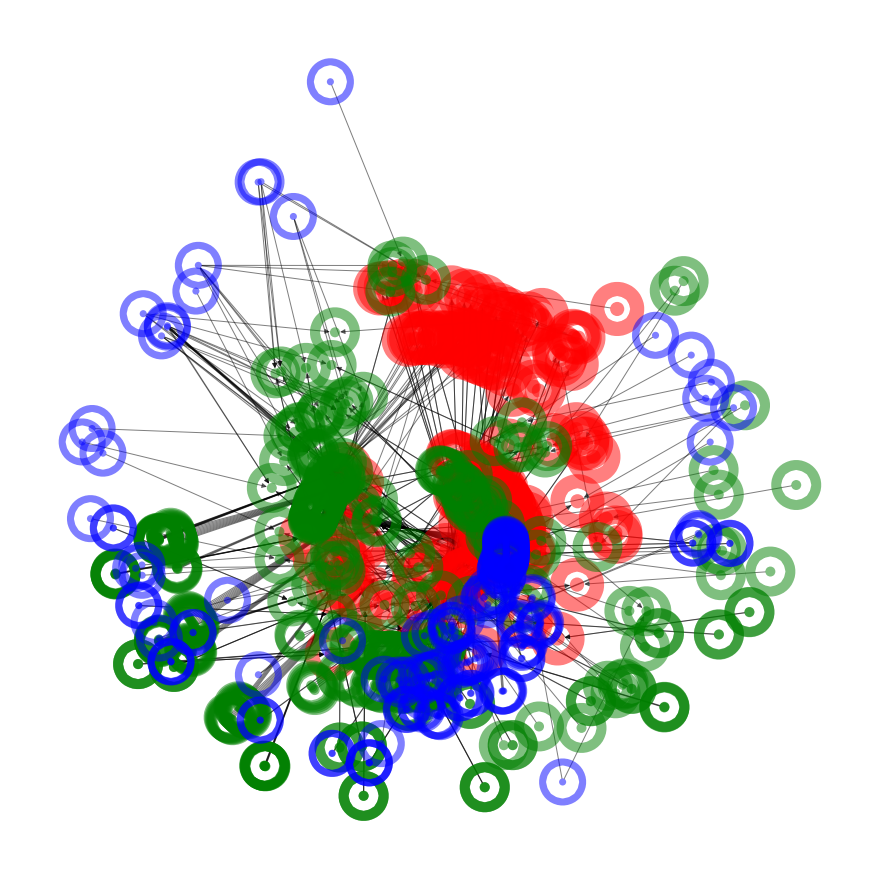

In [77]:
visualize_heterograph(sampled_data)

> That one seems to work :

In [173]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels , conv=SAGEConv):
        super().__init__()
        self.conv = conv(-1, hidden_channels, aggr='mean')  # Use 'mean' aggregation
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)  # GNN layer (feature transformation)
        return x
        
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, features_A, features_B1, graph_data):
        index_B1 , index_A = graph_data["B1", "infects", "A"].edge_label_index
        z = torch.cat([features_B1[index_B1] ,features_A[index_A]], dim=-1)  # Can you explain why this line gives me an error 
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

class Model(torch.nn.Module):
    def __init__(self, out_channels , conv=SAGEConv):
        super().__init__()
        self.gnn_B2_B1 = GNN(out_channels, conv)  # Use GNN instead of conv
        self.gnn_B1_A = GNN(out_channels, conv)  # Use GNN instead of conv
        self.decode = EdgeDecoder(out_channels)
        
    def forward(self, graph_data):
        # Propagate B2 features to B1 : prop 1 
        prop_1_x = graph_data.x_dict["B1"]
        prop_1_edge = graph_data.edge_index_dict[('B2','expressed','B1')]
        features_B1_updated = self.gnn_B2_B1(prop_1_x, prop_1_edge)  # Added edge_index_B2_B1        
        # Propagate new B1 features to A : prop 2 
        prop_2_edge = graph_data.edge_index_dict[('B1','infects','A')]  # Fixed the variable name from sampled_data to graph_data
        features_A_updated = self.gnn_B1_A(features_B1_updated, prop_2_edge)  # Added edge_index_B1_A
        return self.decode(features_A_updated , features_B1_updated, graph_data)


> See if the to hetero actually works (No ...)

In [155]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(-1, hidden_channels, add_self_loops=False)
        self.conv2 = SAGEConv(-1, out_channels, add_self_loops=False)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Model(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.encoder = GNN(hidden_channels , out_channels)  # Use GNN instead of conv
        node_types = ['A', 'B1', 'B2']
        edge_types = [('B1', 'infects', 'A'), ('B2', 'expressed', 'B1'), ('A', 'harbors', 'B1')]
        metadata = [node_types , edge_types]
        self.encoder = to_hetero(self.encoder , metadata)   # Use GNN instead of conv
        
    def forward(self, graph_data):
        z_dict = self.encoder(graph_data.x_dict, graph_data.edge_index_dict)
        return  z_dict


In [139]:
graph_data

HeteroData(
  A={ x=[4530, 127] },
  B1={ x=[11339, 0] },
  B2={ x=[3608, 1280] },
  (B1, infects, A)={
    edge_index=[2, 9677],
    y=[9677]
  },
  (B2, expressed, B1)={
    edge_index=[2, 13285],
    y=[13285]
  },
  (A, harbors, B1)={
    edge_index=[2, 9677],
    y=[9677]
  }
)

> 1706 version of the GNN

***
### Same single layer
> Dot product

In [145]:
class GNN(torch.nn.Module):
    def __init__(self, edge_type , hidden_channels, conv=SAGEConv): # GCNConv(-1, 64) , SAGEConv((-1, -1), 64), GATConv((-1, -1), 64)
        super().__init__()
        self.conv = conv((-1,-1), hidden_channels, add_self_loops = False)
        self.hetero_conv = HeteroConv({edge_type: self.conv},aggr='mean')
    def forward(self, x_dict, edge_index_dict):
        x = self.hetero_conv(x_dict, edge_index_dict)  
        return x

# Dot product :
class Classifier(torch.nn.Module):
    def forward(self, x_dict_A , x_dict_B1, edge_index):
        edge_type = ("B1", "infects", "A")
        edge_feat_A = x_dict_A["A"][edge_index[edge_type].edge_label_index[1]]
        edge_feat_B1 = x_dict_B1["B1"][edge_index[edge_type].edge_label_index[0]]
        return (edge_feat_A * edge_feat_B1).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, out_channels , conv=SAGEConv):
        super().__init__()
        self.single_layer_model = GNN(("B2", "expressed", "B1") , out_channels) 
        self.second_layer_model = GNN(("B1", "infects", "A") , out_channels)
        self.classifier_dot = Classifier()
        
    def forward(self, graph_data):
        b1_nodes = self.single_layer_model(graph_data.x_dict , graph_data.edge_index_dict)
        updated_dict = {}
        updated_dict["A"], updated_dict["B2"] = graph_data.x_dict["A"], graph_data.x_dict["B2"]
        updated_dict["B1"] = b1_nodes["B1"]
        a_nodes = self.second_layer_model(updated_dict , graph_data.edge_index_dict)
        dot_product = self.classifier_dot(a_nodes ,b1_nodes , graph_data)
        
        return dot_product

        

> Dot product with the activation function

In [111]:
class GNN(torch.nn.Module):
    def __init__(self, edge_type , hidden_channels, conv=SAGEConv): # GCNConv(-1, 64) , SAGEConv((-1, -1), 64), GATConv((-1, -1), 64)
        super().__init__()
        self.conv = conv((-1,-1), hidden_channels, add_self_loops = False)
        self.hetero_conv = HeteroConv({edge_type: self.conv},aggr='mean')
        self.activation = torch.nn.ReLU() # or any other activation function you prefer

    def forward(self, x_dict, edge_index_dict):
        x = self.hetero_conv(x_dict, edge_index_dict)
        x = {k: self.activation(v) for k, v in x.items()}  # apply activation function
        return x

# Dot product :
class Classifier(torch.nn.Module):
    def forward(self, x_dict_A , x_dict_B1, edge_index):
        edge_type = ("B1", "infects", "A")
        edge_feat_A = x_dict_A["A"][edge_index[edge_type].edge_label_index[1]]
        edge_feat_B1 = x_dict_B1["B1"][edge_index[edge_type].edge_label_index[0]]
        return (edge_feat_A * edge_feat_B1).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, out_channels , conv=SAGEConv):
        super().__init__()
        self.single_layer_model = GNN(("B2", "expressed", "B1") , out_channels) 
        self.second_layer_model = GNN(("B1", "infects", "A") , out_channels)
        self.classifier_dot = Classifier()
        
    def forward(self, graph_data):
        b1_nodes = self.single_layer_model(graph_data.x_dict , graph_data.edge_index_dict)
        updated_dict = {}
        updated_dict["A"], updated_dict["B2"] = graph_data.x_dict["A"], graph_data.x_dict["B2"]
        updated_dict["B1"] = b1_nodes["B1"]
        a_nodes = self.second_layer_model(updated_dict , graph_data.edge_index_dict)
        dot_product = self.classifier_dot(a_nodes ,b1_nodes , graph_data)
        
        return dot

> Debugg

In [144]:
sampled_data

HeteroData(
  A={
    x=[160, 127],
    n_id=[160]
  },
  B1={
    x=[277, 0],
    n_id=[277]
  },
  B2={
    x=[132, 1280],
    n_id=[132]
  },
  (B1, infects, A)={
    edge_index=[2, 261],
    y=[261],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[261],
    input_id=[128]
  },
  (B2, expressed, B1)={
    edge_index=[2, 164],
    y=[164],
    e_id=[164]
  },
  (A, harbors, B1)={
    edge_index=[2, 127],
    y=[127],
    e_id=[127]
  }
)

> FNN

In [ ]:
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, features_A, features_B1, graph_data):
        index_B1 , index_A = graph_data["B1", "infects", "A"].edge_label_index
        z = torch.cat([features_B1[index_B1] ,features_A[index_A]], dim=-1)  # Can you explain why this line gives me an error 
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [141]:
sampled_data = next(iter(train_loader))
#sampled_data.x_dict["A"][0] , sampled_data.x_dict["A"][1]
#for edge_index,index in enumerate(sampled_data.edge_index_dict[('B1','infects','A')]) :

sampled_data[("B1", "infects", "A")].edge_label_index

tensor([[ 81,  26,  15,  29,  97,  12, 109,  84, 124,  77,  49,  83,   7,  44,
         115,  69,  92,  25, 122,  13,  99,  73,   0,  56,  10,  23,  43,  59,
          85, 104,  60, 126,  18,  50, 107, 114,  75,  80,  21,  95, 119,  63,
          71,  34,  67,  45,  90,  33,  78,  93,  35,  57,   3,  40,  62,  16,
          61,  91,   1, 125,  11,  87,  58,   6,  65,  66, 123,  72,  32,   5,
          94,  70, 106,  38,  82,   9, 100,  27, 116,  22,   8,  28,  46,  86,
          76,  37,  48, 118, 102,   4,  24,  54,  17, 117,  89,  51, 113, 103,
          14, 112,  42,   2,  19, 105,  52, 127, 101,  79, 110,  53, 121,  39,
          30,  20,  36,  96, 111, 120,  98,  64,  55,  68, 108,  74,  41,  47,
          88,  31],
        [ 62,  40,  29,  16,  15,  18,  56, 108,  76, 104,  66, 124,  11,  55,
          95,  14,  24,  26,  54,  27,  47, 100,   0,  73,  20,  91,  61,  80,
         109, 125,  81,  70,  23,  67,  96,  63,  12,  72,  53,  49, 102,  22,
          97,  35,  88, 122, 113

In [146]:
model = Model(20)

dot = model(sampled_data)
dot

tensor([-0.0542,  0.0034, -0.0519, -0.0532, -0.0320, -0.0283, -0.0135, -0.0459,
        -0.0874, -0.0219, -0.0004, -0.0549, -0.0459, -0.0304, -0.0278, -0.0111,
        -0.0021, -0.0442, -0.0214, -0.0512, -0.0135, -0.0460, -0.0380, -0.0257,
        -0.0502,  0.0047,  0.0047, -0.0560, -0.0109, -0.0034, -0.0148, -0.0463,
        -0.0372, -0.0849,  0.0103, -0.0348,  0.0180, -0.0219, -0.0362, -0.0287,
        -0.0221, -0.0283, -0.0366, -0.0273, -0.0422, -0.0371, -0.0264, -0.0725,
        -0.0250, -0.0257, -0.0331, -0.0497,  0.0024, -0.0116, -0.0122, -0.0542,
        -0.0505, -0.0239, -0.0169, -0.0105, -0.0394, -0.0147, -0.0208, -0.0397,
         0.0446, -0.0111, -0.0267,  0.0030, -0.0551, -0.0467, -0.0552, -0.0078,
        -0.0192, -0.0273,  0.0032, -0.0502, -0.0507, -0.0387, -0.0213, -0.0807,
        -0.0440, -0.0342, -0.0327, -0.0453, -0.0573, -0.0389, -0.0116, -0.0096,
        -0.0147, -0.0388,  0.0031, -0.0486, -0.0227, -0.0132, -0.0173, -0.0461,
        -0.0286,  0.0042, -0.0670, -0.04

In [120]:
len(dot) , sampled_data

(257,
 HeteroData(
   A={
     x=[154, 127],
     n_id=[154]
   },
   B1={
     x=[269, 0],
     n_id=[269]
   },
   B2={
     x=[144, 1280],
     n_id=[144]
   },
   (B1, infects, A)={
     edge_index=[2, 257],
     y=[257],
     edge_label=[128],
     edge_label_index=[2, 128],
     e_id=[257],
     input_id=[128]
   },
   (B2, expressed, B1)={
     edge_index=[2, 173],
     y=[173],
     e_id=[173]
   },
   (A, harbors, B1)={
     edge_index=[2, 128],
     y=[128],
     e_id=[128]
   }
 ))

In [138]:
sampled_data[("B1", "infects", "A")].edge_index

tensor([[128, 128, 129,  46, 130, 131, 132,  96, 133, 134, 135, 136, 137, 138,
           2, 139,  20, 140,  20, 141, 142,   6, 143, 144, 143,   6, 145, 146,
         147, 148, 149,  44, 150, 151, 152, 153,   0,   0, 154, 155, 156,  78,
         154,   5, 157, 158, 159,  31, 159, 159, 160, 161, 162, 163, 164, 164,
         161, 165,  77, 166, 167, 168, 169, 170, 171, 172, 173, 174, 106, 175,
         176, 177,   3, 178, 179, 179, 180, 181, 182,  29, 183, 184, 185,  53,
         186,   4, 187, 188,  38, 189,  38, 189,   7,   7, 190,   8,   9, 191,
         191, 191, 192, 191, 193, 194,  10,  10,  10, 195,  16, 195,  16,  11,
         196,  11, 197, 198, 199, 200, 201, 202, 203,  34, 204, 205, 206, 207,
         208,  18, 209,  94,  94, 209, 209, 210,  19, 210,  19, 210,  21, 211,
          22,  22, 212, 213,  23, 214, 215, 215, 216,  27, 217, 218, 219,  30,
          36,  37,  37, 220,  92, 221, 222,  41, 223, 223, 224, 225, 226,  98,
         227, 228,  45, 229,  48, 230,  49,  51, 231

In [121]:
single_layer_model = GNN(("B2", "expressed", "B1") , 20) 
second_layer_model = GNN(("B1", "infects", "A") , 20) 
classifier_dot = Classifier()

b1_nodes = single_layer_model(sampled_data.x_dict , sampled_data.edge_index_dict)
updated_dict = {}
updated_dict["A"], updated_dict["B2"] = sampled_data.x_dict["A"], sampled_data.x_dict["B2"]
updated_dict["B1"] = b1_nodes["B1"]

a_nodes = second_layer_model(updated_dict , sampled_data.edge_index_dict)
a_nodes
dot = classifier_dot(a_nodes ,b1_nodes , sampled_data)

In [122]:
dot

tensor([ 0.0015,  0.0015,  0.0015, -0.0293, -0.0293,  0.0015,  0.0015,  0.0015,
         0.0015,  0.0015, -0.0266,  0.0015,  0.0011,  0.0011,  0.0011,  0.0011,
         0.0011,  0.0011,  0.0011,  0.0014,  0.0014, -0.0298,  0.0014,  0.0019,
        -0.0071,  0.0011, -0.0119,  0.0018,  0.0018,  0.0018, -0.0119, -0.0122,
         0.0018, -0.0122,  0.0018,  0.0018,  0.0021,  0.0018,  0.0017, -0.0350,
         0.0017,  0.0015,  0.0015,  0.0015, -0.0414,  0.0011,  0.0011,  0.0011,
         0.0776,  0.0110,  0.0110,  0.0011,  0.0011,  0.0011,  0.0011,  0.0011,
        -0.0103,  0.0016,  0.0106,  0.0106,  0.0106,  0.0108,  0.0108,  0.0662,
         0.0108,  0.0108,  0.0929,  0.0115,  0.0011,  0.0011,  0.0011,  0.0011,
         0.0106,  0.0106,  0.0011,  0.0011,  0.0011,  0.0011,  0.0016,  0.0016,
        -0.0263,  0.0011,  0.0011,  0.0011,  0.0023,  0.0025,  0.1001,  0.0023,
        -0.0176,  0.0018,  0.0018,  0.0023,  0.0018,  0.0018,  0.0023,  0.1390,
         0.1390,  0.0124,  0.1139,  0.11

With activation function

In [ ]:
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, features_A, features_B1, graph_data):
        index_B1 , index_A = graph_data["B1", "infects", "A"].edge_label_index
        z = torch.cat([features_B1[index_B1] ,features_A[index_A]], dim=-1)  # Can you explain why this line gives me an error 
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

class Model(torch.nn.Module):
    def __init__(self, out_channels , conv=SAGEConv):
        super().__init__()
        self.gnn_B2_B1 = GNN(out_channels, conv)  # Use GNN instead of conv
        self.gnn_B1_A = GNN(out_channels, conv)  # Use GNN instead of conv
        self.decode = EdgeDecoder(out_channels)
        
    def forward(self, graph_data):
        # Propagate B2 features to B1 : prop 1 
        prop_1_x = graph_data.x_dict["B1"]
        prop_1_edge = graph_data.edge_index_dict[('B2','expressed','B1')]
        features_B1_updated = self.gnn_B2_B1(prop_1_x, prop_1_edge)  # Added edge_index_B2_B1        
        # Propagate new B1 features to A : prop 2 
        prop_2_edge = graph_data.edge_index_dict[('B1','infects','A')]  # Fixed the variable name from sampled_data to graph_data
        features_A_updated = self.gnn_B1_A(features_B1_updated, prop_2_edge)  # Added edge_index_B1_A
        return self.decode(features_A_updated , features_B1_updated, graph_data)

In [156]:

node_types = ['A', 'B1', 'B2']
edge_types = [('B1', 'infects', 'A'), ('B2', 'expressed', 'B1'), ('A', 'harbors', 'B1')]
metadata = [node_types , edge_types]
sampled_data.edge_types


[('B1', 'infects', 'A'), ('B2', 'expressed', 'B1'), ('A', 'harbors', 'B1')]

In [157]:
debug_Model = Model(10 , 10) 

a = debug_Model(sampled_data)

NotImplementedError: 

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(-1, hidden_channels, add_self_loops=False)
        self.conv2 = GCNConv(-1, out_channels, add_self_loops=False)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [171]:
sampled_data[('B1','infects','A')].edge_label

tensor([0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
        0., 0.])

In [ ]:
# *****************************************************************************
# Training :
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

def train(model, loader, optimizer, criterion, edge_type):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        edge_labels = data[edge_type].edge_label
        loss = criterion(out, edge_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, criterion, edge_type):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []  # Collect output probabilities for AUC
    for data in loader:
        data = data.to(device)
        out = model(data)
        edge_labels = data[edge_type].edge_label
        val_loss = criterion(out, edge_labels)
        total_loss += val_loss.item()
        probs = torch.sigmoid(out)  # Convert output to probabilities
        pred_class = probs.round()  # Round to nearest integer to get class predictions
        all_preds.extend(pred_class.cpu().numpy())
        all_labels.extend(edge_labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Collect output probabilities
    # Calculate the metrics
    f1 = f1_score(all_labels, all_preds, average='binary')
    precision = precision_score(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)  # Use probabilities, not class predictions
    return total_loss / len(loader), f1, precision, accuracy, auc

def main():
    hidden_channels = 1000
    model = Model(hidden_channels).to(device)
    # Due to lazy initialization, we need to run one model step so the number
    # of parameters can be inferred:
    eg_gratia_data = next(iter(val_loader))
    edge_type = ("B1", "infects", "A")
    with torch.no_grad():
        model(eg_gratia_data)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(1000):
        train_loss = train(model, train_loader, optimizer, criterion, edge_type)
        if epoch % 10 == 0:
            test_loss, f1, precision, accuracy, auc = evaluate(model, test_loader, criterion, edge_type)
            print(f'Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}, F1 Score: {f1}, Precision: {precision}, Accuracy: {accuracy}, AUC: {auc}')
    # Save the model
    torch.save(model.state_dict(), f"{path_work}/SAGEConv.dot.model.1707.pt")

if __name__ == "__main__":
    main()



In [ ]:
# *****************************************************************************
# Training :
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

def train(model, loader, optimizer, criterion, edge_type):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        edge_labels = data[edge_type].y[data[edge_type].train_mask]
        loss = criterion(out[data[edge_type].train_mask], edge_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, criterion, edge_type):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in loader:
        data = data.to(device)
        pred = model(data)
        edge_labels = data[edge_type].y[data[edge_type].val_mask]
        val_loss = criterion(pred[data[edge_type].val_mask], edge_labels)
        total_loss += val_loss.item()
        _, pred_class = pred.max(dim=1)
        all_preds.extend(pred_class.cpu().numpy())
        all_labels.extend(edge_labels.cpu().numpy())
    # Calculate the metrics
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(loader), f1, precision, accuracy, auc

def main():
    hidden_channels = 580 
    out_channels = 100 
    model = Model(hidden_channels, out_channels).to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    edge_type = ("B1", "infects", "A")  # adjust this as per your requirement
    for epoch in range(100): 
        train_loss = train(model, train_loader, optimizer, criterion, edge_type)
        if epoch % 10 == 0:
            test_loss, f1, precision, accuracy, auc = evaluate(model, test_loader, criterion, edge_type)
            print(f'Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}, F1 Score: {f1}, Precision: {precision}, Accuracy: {accuracy}, AUC: {auc}')
    # Save the model
    torch.save(model.state_dict(), f"{path_work}/GCNConv.model.1307.pt")

if __name__ == "__main__":
    main()

In [ ]:
#!/bin/bash
#BATCH --job-name=GCNConv__
#SBATCH --qos=short
#SBATCH --ntasks=1 
#SBATCH --cpus-per-task=10 
#SBATCH --mem=100gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=GCNConv__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate torch_geometric

python /home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/train_nn/script_files/GCNConv_Hetero.dot.py


In [ ]:
# Cross-validation
for fold, (train_idx, test_idx) in enumerate(kfold.split(graph_data.node_items['A'], graph_data.y)):
    train_data = graph_data[train_idx]
    test_data = graph_data[test_idx]
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32)
    for epoch in range(100):  # adjust as needed
        train_loss = train(model, train_loader, optimizer, criterion)
        print(f"Fold: {fold+1}, Epoch: {epoch+1}, Train loss: {train_loss}")
    acc, prec, rec, f1, auroc = test(model, test_loader)
    print(f"Fold: {fold+1}, Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1-score: {f1}, AUROC: {auroc}")

